## トピック分類

#### データ準備

In [ ]:
!pip install portalocker

In [ ]:
from torchtext import datasets
from sklearn.model_selection import train_test_split
data = datasets.AG_NEWS(split='train')
data = list(data)
train_data, remaining = train_test_split(data, train_size=0.1, random_state=0)
_, val_data = train_test_split(remaining, test_size=0.1, random_state=0)

In [ ]:
# 1: "World", 2:"Sports", 3:"Business", 4:"Sci/Tech"
list(data)[:3]

[(3,
  "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."),
 (3,
  'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'),
 (3,
  "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")]

In [ ]:
import pandas as pd
labels = [label for label, text in data]
labels = pd.Series(labels)
labels.value_counts()

3    30000
4    30000
2    30000
1    30000
dtype: int64

<Axes: ylabel='Count'>

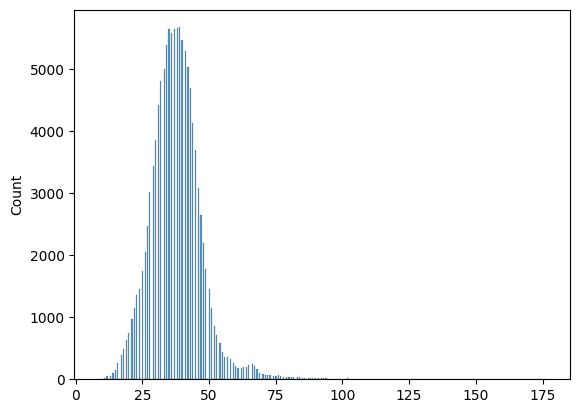

In [ ]:
import seaborn as sns
text_lens = pd.Series([len(text.split()) for _, text in data])
sns.histplot(text_lens)

#### データ準備

In [ ]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")

In [ ]:
tokenizer("I am a student")

['i', 'am', 'a', 'student']

#### イテレータ作成

In [ ]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

In [ ]:
# next(yiled_tokens(data))

#### 辞書作成

In [ ]:
from torchtext.vocab import build_vocab_from_iterator
vocab = build_vocab_from_iterator(yield_tokens(data), specials=['<unk>'])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
vocab["hello"]

12544

In [ ]:
# 存在しない単語のindex
vocab["xxxx"]

0

In [ ]:
# indexからの逆引き
vocab.get_itos()[12544]

'hello'

#### DataLoader作成

In [ ]:
train_data[:3]

[(2,
  'SECOND LOOKSnapshots from the latest in college football The boys of Pi Kappa Phi better look out. Mississippi State pulls off the SEC stunner of this Millennium, beating Ron Zook and Florida 38-31.'),
 (1,
  'Summit of French-Speaking Countries Condemns Ivory Coast Leaders at a summit in Burkina Faso of mostly French-speaking nations have condemned authorities in divided Ivory Coast for resuming hostilities in the rebel-held north earlier this month.'),
 (4,
  'Lost faith in Internet Explorer? Try another browser Microsoft has won the browser wars, but a battle is raging for the runner-up spot and one of the contenders has recently been refreshed.')]

In [ ]:
# batch: [(label, text), (label, text),...,]
import torch
from torch.nn.utils.rnn import pad_sequence
def collate_batch(batch):
    label_list = []
    text_list = []
    for label, text in batch:
        label_list.append(label - 1)
        text_list.append(torch.tensor([vocab[token] for token in tokenizer(text)])) # ["I am a student"] - >["I", "am", "a", "student"] -> (ex.)[4, 1, 6, 7]

    # padding
    label_list = torch.tensor(label_list)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    return label_list, text_list

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=8, collate_fn=collate_batch, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, collate_fn=collate_batch, shuffle=False)

In [ ]:
label, text = next(iter(train_loader))

In [ ]:
label

tensor([2, 2, 3, 0, 3, 1, 2, 2])

### word embedding matrixの作成

In [ ]:
# gensimのword2vecを使用

# google drive のマウント
from google.colab import drive
drive_path = '/content/drive'
drive.mount(drive_path)

from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(f'{drive_path}/MyDrive/models/GoogleNews-vectors-negative300.bin', binary=True)

Mounted at /content/drive


In [ ]:
import numpy as np
# unkownには，word2vecの全単語の平均のベクトルを適用する
unk_vector = torch.from_numpy(np.mean(word2vec.vectors, axis=0))
embedding_matrix = torch.zeros((len(vocab), 300))
for i, word in enumerate(vocab.get_itos()):
    if word in word2vec:
        embedding_matrix[i] = torch.from_numpy(word2vec[word])
    else:
        embedding_matrix[i] = unk_vector

<ipython-input-19-4b40536924b1>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  embedding_matrix[i] = torch.from_numpy(word2vec[word])


### モデル

In [ ]:
import torch.nn as nn
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix=None, num_layers=1, rnn_type='LSTM', bidirectional=False):

        super().__init__()
        self.hidden_size = hidden_size
        self.num_directions = 2 if bidirectional else 1

        # embedding layer追加 (vocab_size x embedding_dim)
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) # embedding matrixで重みを初期化
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        input_size = embedding_dim

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError('Unsupported RNN type. Choose from ["LSTM", "RNN", "GRU", "UGRNN"]')

        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output_seq, _ = self.rnn(x)
        output_seq = output_seq[:, -1, :]
        # output_seq: [batch_size, seq_len, hidden_size*num_directions]
        out = self.fc(output_seq)
        return out

### 学習ループ

In [ ]:
# 学習ループ
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for i, (labels, sentences) in enumerate(train_loader):
            sentences = sentences.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(sentences)
            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}")

        # 検証データを使用して検証エラーを計算
        model.eval()
        val_loss = 0
        total_samples = 0
        total_correct = 0
        for labels, sentences in val_loader:
            sentences = sentences.to(device)
            labels = labels.to(device)

            outputs = model(sentences)
            # loss計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # accuracy計算
            _, predicted = torch.max(outputs, dim=-1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.numel()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = total_correct / total_samples
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

In [ ]:
vocab_size = len(vocab)
num_classes = 4
embedding_dim = 300
hidden_size = 64
output_size = num_classes
learning_rate = 0.001
num_epochs = 3
num_layers = 1

# モデル作成
model = Model(vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix=embedding_matrix, num_layers=num_layers, rnn_type='LSTM', bidirectional=True)

# 損失関数とOptimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
train(model, train_loader, val_loader, optimizer, criterion, num_epochs)

Epoch 1/3, Average Training Loss: 0.4860
Val Loss: 0.3318, Val Accuracy: 0.8891
Epoch 2/3, Average Training Loss: 0.1938
Val Loss: 0.4326, Val Accuracy: 0.8625
Epoch 3/3, Average Training Loss: 0.0884
Val Loss: 0.3630, Val Accuracy: 0.8888
